https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard

In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import warnings
warnings.filterwarnings('ignore')

from scipy import stats

from sklearn.metrics import mean_squared_error, mean_squared_log_error

In [2]:
train_df = pd.read_csv("./input/train.csv")
test_df = pd.read_csv("./input/test.csv")
match_df = pd.read_csv("./input/match_reports.csv")
holiday_df = pd.read_csv("./input/holidays_in_japan.csv")
stadium_df = pd.read_csv("./input/stadium_capacity_mapping.csv")
smpsb_df = pd.read_csv("./input/sample_submit.csv", header=None)
rank_df = pd.read_csv('./input/rank.csv',encoding='cp932')

In [3]:
#欠損値の確認
print(train_df.isnull().sum())
print(test_df.isnull().sum())

id               0
match_date       0
kick_off_time    0
section          0
round            0
home_team        0
away_team        0
venue            0
weather          0
temperature      0
humidity         0
broadcasters     0
attendance       0
dtype: int64
id                0
match_date        0
kick_off_time     0
section           0
round             0
home_team         0
away_team         0
venue             0
weather          18
temperature      18
humidity         18
broadcasters      0
dtype: int64


In [4]:
test_df = test_df.dropna()
test_df.isnull().sum()

id               0
match_date       0
kick_off_time    0
section          0
round            0
home_team        0
away_team        0
venue            0
weather          0
temperature      0
humidity         0
broadcasters     0
dtype: int64

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3366 entries, 0 to 3365
Data columns (total 13 columns):
id               3366 non-null int64
match_date       3366 non-null object
kick_off_time    3366 non-null object
section          3366 non-null object
round            3366 non-null object
home_team        3366 non-null object
away_team        3366 non-null object
venue            3366 non-null object
weather          3366 non-null object
temperature      3366 non-null float64
humidity         3366 non-null int64
broadcasters     3366 non-null object
attendance       3366 non-null int64
dtypes: float64(1), int64(3), object(9)
memory usage: 341.9+ KB


In [6]:
train_df.describe()

,id,temperature,humidity,attendance
count,3366.000000,3366.000000,3366.000000,3366.000000
mean,13477.227273,21.015805,60.789067,17961.112299
std,2687.674753,6.112729,18.570777,9468.784878
min,9190.000000,0.800000,12.000000,0.000000
25%,11032.250000,16.500000,47.000000,11490.500000
50%,13390.500000,21.800000,62.000000,15322.000000
75%,15744.750000,26.100000,76.000000,21084.750000
max,18199.000000,34.200000,99.000000,62632.000000


In [7]:
test_df.describe()

,id,temperature,humidity
count,459.000000,459.000000,459.000000
mean,19758.666667,21.059477,57.407407
std,755.892217,5.701610,18.870092
min,19075.000000,6.600000,20.000000
25%,19189.500000,17.150000,42.000000
50%,19304.000000,22.000000,57.000000
75%,20782.500000,25.200000,72.000000
max,20897.000000,33.600000,95.000000


In [8]:
#開催日時をdatetimeに
train_df.match_date = pd.to_datetime(train_df.match_date)
test_df.match_date = pd.to_datetime(test_df.match_date)

### 開催年月日を抽出

In [9]:
match_date = train_df.match_date
month_list = []
year_list = []
day_list = []
for i in range(len(match_date)):
    year_list.append(match_date.iloc[i].year)
    month_list.append(match_date.iloc[i].month)
    day_list.append(match_date.iloc[i].day)
train_df['match_date_year'] = year_list
train_df['match_date_month'] = month_list
train_df['match_date_day'] = day_list


match_date = test_df.match_date
month_list = []
year_list = []
day_list = []
for i in range(len(match_date)):
    year_list.append(match_date.iloc[i].year)
    month_list.append(match_date.iloc[i].month)
    day_list.append(match_date.iloc[i].day)
test_df['match_date_year'] = year_list
test_df['match_date_month'] = month_list
test_df['match_date_day'] = day_list

### 目的変数

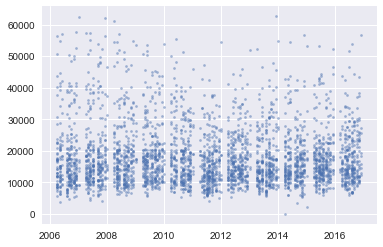

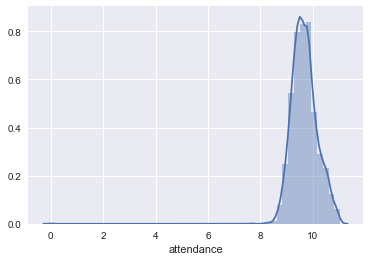

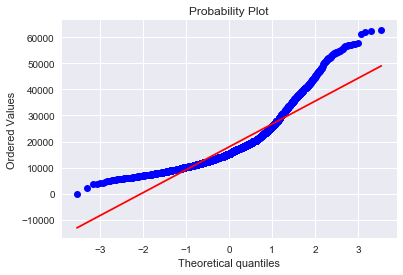

In [10]:
# 時系列プロット
# 2014年に観客数の少ない回がある
x = train_df["match_date_year"] + train_df["match_date_month"] / 12 
y = train_df["attendance"]
plt.scatter(x, y, alpha=0.5, s=5)

plt.figure()
sns.distplot(np.log1p(train_df.attendance))

fig = plt.figure()
res = stats.probplot(train_df.attendance, plot=plt)

In [11]:
# 2014/3/23の試合は無観客試合
#2014/12/8は大雪で延期になった試合
#J1昇格チームが低そう
train_df.query("attendance <= 5000")[["match_date", "home_team", "away_team", "attendance"]]

,match_date,home_team,away_team,attendance
48,2006-04-02,京都,福岡,3670
182,2006-08-30,大宮,福岡,4873
387,2007-05-06,横浜FC,神戸,4458
414,2007-05-26,横浜FC,大分,4935
569,2007-10-27,横浜FC,大宮,4114
1564,2011-07-13,福岡,大宮,4028
2479,2014-03-23,浦和,清水,0
2608,2014-08-02,徳島,甲府,3594
2749,2014-12-08,新潟,柏,2104


In [12]:
#2013年11月30日は横浜が優勝しそうになったから観客数が多い
train_df.query("attendance >= 55000")[["match_date", "home_team", "away_team", "attendance"]]

,match_date,home_team,away_team,attendance
9,2006-03-11,浦和,磐田,56512
106,2006-05-07,浦和,鹿島,56982
280,2006-11-23,浦和,甲府,57781
298,2006-12-02,浦和,G大阪,62241
311,2007-03-03,浦和,横浜FC,57188
378,2007-05-03,浦和,千葉,57440
404,2007-05-13,浦和,G大阪,55258
586,2007-11-18,浦和,清水,56368
594,2007-11-24,浦和,鹿島,62123
614,2008-03-08,横浜FM,浦和,61246


#### 外れ値除き対数変換してみる

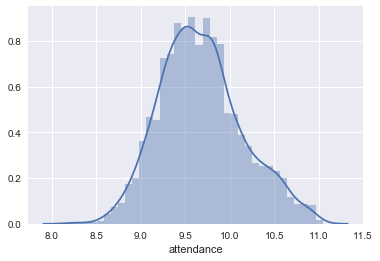

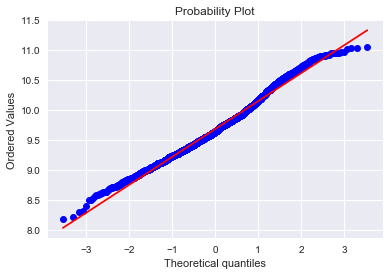

In [13]:
train_df.drop(2479, inplace=True)  # 無観客試合
train_df.drop(2749, inplace=True)  #大雪で開催中止になって2日後に鹿島で代替試合した

sns.distplot(np.log1p(train_df.attendance))

fig = plt.figure()
res = stats.probplot(np.log1p(train_df.attendance), plot=plt)

# 前処理

In [14]:
# データフレームを一つにまとめる
target = train_df.attendance
total_df = pd.concat([train_df, test_df])

In [15]:
total_df.describe()

,attendance,humidity,id,match_date_day,match_date_month,match_date_year,temperature
count,3364.000000,3823.000000,3823.000000,3823.000000,3823.000000,3823.000000,3823.000000
mean,17971.165279,60.392362,14230.161130,16.497777,6.846717,2011.758828,21.025974
std,9462.579483,18.631907,3255.280615,8.824377,2.644573,3.615249,6.061011
min,3594.000000,12.000000,9190.000000,1.000000,2.000000,2006.000000,0.800000
25%,11495.750000,46.000000,11653.500000,9.000000,4.000000,2009.000000,16.600000
50%,15327.500000,62.000000,14069.000000,17.000000,7.000000,2012.000000,21.800000
75%,21091.250000,76.000000,16917.500000,24.000000,9.000000,2015.000000,26.000000
max,62632.000000,99.000000,20897.000000,31.000000,12.000000,2018.000000,34.200000


In [16]:
total_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3823 entries, 0 to 458
Data columns (total 16 columns):
attendance          3364 non-null float64
away_team           3823 non-null object
broadcasters        3823 non-null object
home_team           3823 non-null object
humidity            3823 non-null float64
id                  3823 non-null int64
kick_off_time       3823 non-null object
match_date          3823 non-null datetime64[ns]
match_date_day      3823 non-null int64
match_date_month    3823 non-null int64
match_date_year     3823 non-null int64
round               3823 non-null object
section             3823 non-null object
temperature         3823 non-null float64
venue               3823 non-null object
weather             3823 non-null object
dtypes: datetime64[ns](1), float64(3), int64(4), object(8)
memory usage: 507.7+ KB


In [17]:
total_df.isnull().sum()

attendance          459
away_team             0
broadcasters          0
home_team             0
humidity              0
id                    0
kick_off_time         0
match_date            0
match_date_day        0
match_date_month      0
match_date_year       0
round                 0
section               0
temperature           0
venue                 0
weather               0
dtype: int64

### スタジアムのキャパシティーを追加

In [18]:
stadium_capacity_dic = stadium_df.to_dict(orient='dict')
cap_map = {}
for i in range(len(stadium_df)):
    cap_map[stadium_capacity_dic['stadium'][i]] = stadium_capacity_dic['capacity'][i]

In [19]:
total_df['capacity'] = total_df.venue.map(cap_map)

In [20]:
total_df.capacity.describe()

count     3823.000000
mean     31780.394193
std      16100.836699
min      12584.000000
25%      19694.000000
50%      26827.000000
75%      41255.000000
max      72081.000000
Name: capacity, dtype: float64

スタジアム名が変わっているものがある（吹田スタジアム、日立柏サッカー場など）capacityで計算すればOK

In [21]:
total_df.venue.value_counts()

埼玉スタジアム2002                 216
等々力陸上競技場                    212
県立カシマサッカースタジアム              212
味の素スタジアム                    195
日産スタジアム                     181
日立柏サッカー場                    155
万博記念競技場                     149
ヤマハスタジアム(磐田)                146
NACK5スタジアム大宮                142
ユアテックスタジアム仙台                140
東北電力ビッグスワンスタジアム             119
ベストアメニティスタジアム               108
広島ビッグアーチ                    101
山梨中銀スタジアム                    98
ホームズスタジアム神戸                  93
エディオンスタジアム広島                 93
名古屋市瑞穂陸上競技場                  89
豊田スタジアム                      87
IAIスタジアム日本平                  73
ノエビアスタジアム神戸                  69
NDソフトスタジアム山形                 68
フクダ電子アリーナ                    68
デンカビッグスワンスタジアム               67
京都市西京極総合運動公園陸上競技場兼球技場        66
九州石油ドーム                      65
アウトソーシングスタジアム日本平             64
ShonanBMWスタジアム平塚             60
キンチョウスタジアム                   58
日本平スタジアム                     48
大阪長居スタジアム                    41
                           ... 
レベルファイブス

### 休日のダミー変数の追加

In [22]:
holiday_df.holiday_date = pd.to_datetime(holiday_df.holiday_date)
holiday = holiday_df.to_dict(orient='list')

In [23]:
def get_holiday_flg(date):
    #通常の土日
    if date.weekday() >=5:
        return True
    
    if date in holiday['holiday_date']:
        return True
    
    return False

In [24]:
holiday_flg = []
for i in range(len(total_df)):
    holiday_flg.append(1 if get_holiday_flg(total_df.match_date.iloc[i]) else 0)
total_df['holiday'] = holiday_flg

In [25]:
total_df.groupby(['holiday']).size()

holiday
0     380
1    3443
dtype: int64

### キックオフの時間を抽出(分は除く）

In [26]:
kick_off = pd.to_datetime(total_df['kick_off_time'])
kick_off_list = []
for i in range(len(kick_off)):
    kick_off_list.append(kick_off.iloc[i].hour)
total_df['kick_off_time'] = kick_off_list
total_df

,attendance,away_team,broadcasters,home_team,humidity,id,kick_off_time,match_date,match_date_day,match_date_month,match_date_year,round,section,temperature,venue,weather,capacity,holiday
0,20916.0,浦和,NHK総合/J SPORTS(録),G大阪,40.0,9190,16,2006-03-04,4,3,2006,第1日,第1節,8.3,万博記念競技場,晴,21000,1
1,14277.0,清水,山梨放送/テレビ静岡(録)/J SPORTS(録),甲府,28.0,9191,13,2006-03-05,5,3,2006,第2日,第1節,12.9,山梨県小瀬スポーツ公園陸上競技場,晴,15859,1
2,22531.0,大分,BS-i/MXテレビ(録)/J SPORTS(録),FC東京,35.0,9192,13,2006-03-05,5,3,2006,第2日,第1節,12.1,味の素スタジアム,晴,48999,1
3,28564.0,福岡,J SPORTS,磐田,42.0,9193,14,2006-03-05,5,3,2006,第2日,第1節,11.6,静岡スタジアムエコパ,晴,51697,1
4,17199.0,C大阪,スカイパーフェクTV!/NHK名古屋(録)/NHK大阪(録)/J SPORTS(録),名古屋,32.0,9194,14,2006-03-05,5,3,2006,第2日,第1節,13.1,名古屋市瑞穂陸上競技場,晴,20223,1
5,13085.0,千葉,テレビ埼玉/BS(録)/J SPORTS(録),大宮,33.0,9195,15,2006-03-05,5,3,2006,第2日,第1節,12.6,埼玉スタジアム2002,晴,62010,1
6,17444.0,新潟,J SPORTS(録),川崎F,34.0,9196,15,2006-03-05,5,3,2006,第2日,第1節,13.3,等々力陸上競技場,晴,26827,1
7,17564.0,鹿島,BS/J SPORTS(録),広島,58.0,9197,15,2006-03-05,5,3,2006,第2日,第1節,12.4,広島ビッグアーチ,曇,36894,1
8,23607.0,京都,BS-i/KBS京都(録)/J SPORTS(録),横浜FM,34.0,9198,15,2006-03-05,5,3,2006,第2日,第1節,12.6,日産スタジアム,晴,72081,1
9,56512.0,磐田,TBS(単)/静岡放送/テレビ埼玉(録)/J SPORTS(録),浦和,48.0,9199,14,2006-03-11,11,3,2006,第1日,第2節,16.0,埼玉スタジアム2002,晴,62010,1


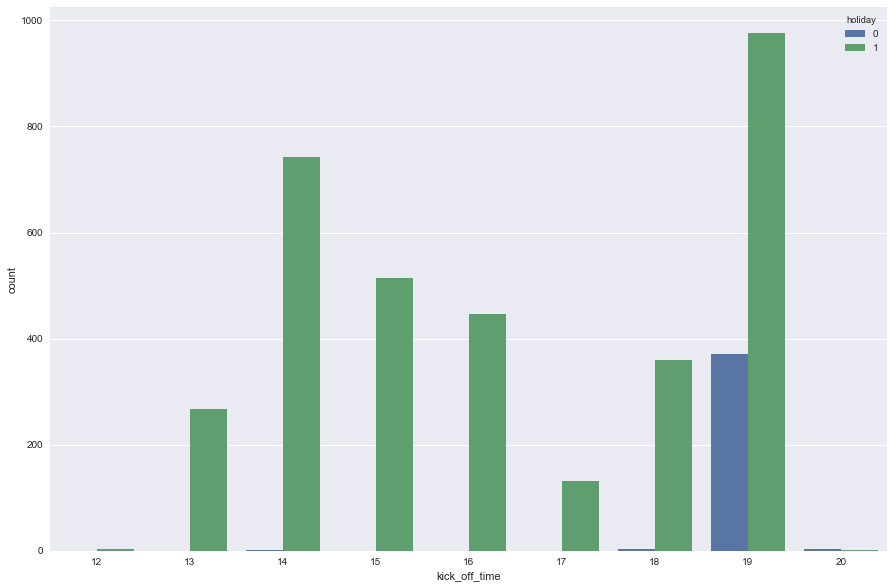

In [27]:
plt.figure(figsize=(15,10))
sns.countplot(x='kick_off_time',hue='holiday',data=total_df)

やはり平日はほぼ18時以降開催

In [28]:
total_df[(total_df['holiday']==0) & (total_df['kick_off_time']<=18)]

,attendance,away_team,broadcasters,home_team,humidity,id,kick_off_time,match_date,match_date_day,match_date_month,match_date_year,round,section,temperature,venue,weather,capacity,holiday
180,11433.0,川崎F,J SPORTS(録),千葉,82.0,9370,18,2006-08-30,30,8,2006,第1日,第21節,24.2,フクダ電子アリーナ,曇,19470,0
181,9457.0,名古屋,BS-i(録)/J SPORTS(録),鹿島,84.0,9371,18,2006-08-30,30,8,2006,第1日,第21節,24.4,県立カシマサッカースタジアム,曇,37496,0
1656,14519.0,G大阪,スカパー/e2/スカパー光,仙台,48.0,13364,14,2011-06-15,15,6,2011,第1日,第15節,21.8,ユアテックスタジアム仙台,晴,19694,0
1674,11356.0,甲府,スカパー/e2/スカパー光,仙台,41.0,13382,14,2011-06-22,22,6,2011,第1日,第17節,31.8,ユアテックスタジアム仙台,晴,19694,0
2924,7524.0,川崎F,スカパー!/スカパー!プレミアムサービス,鳥栖,53.0,16973,18,2015-07-15,15,7,2015,第1日,第2節,29.8,ベストアメニティスタジアム,晴,24130,0


仙台だけ平日の14時に開催。なぜ

15時前開始の試合を昼。16時から18時開始の試合を夕方、19時以降開始の時間を夜とする

In [29]:
#total_df['times'] = total_df.kick_off_time.map(lambda x: 'Noon' if x<=15 else 'Evening' if x<=18 else 'Night')

### 2015,2016年シーズンの節を1シーズン制に直す

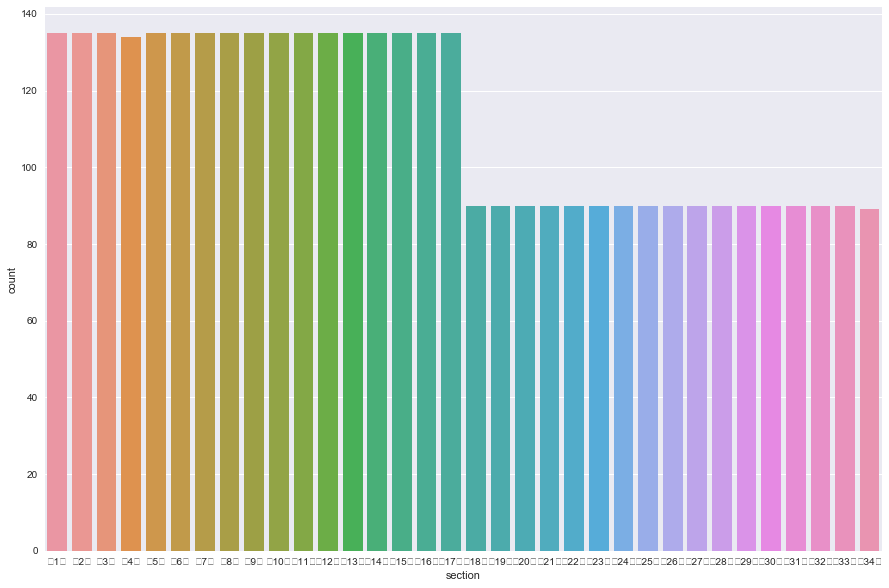

In [30]:
plt.figure(figsize=(15,10))
sns.countplot(x='section',data=total_df)

In [31]:
total_df.loc[:, "section"] = total_df.loc[:, "section"].apply(lambda x: int(x[1:-1]))
total_df.loc[:, "round"] = total_df.loc[:, "round"].apply(lambda x: int(x[1:-1]))

In [32]:
# 両年とも1シーズンに直した時の18節は7月からなので、7月からのsectionを+17する
sec_index = total_df.query("(match_date_year in [2015, 2016])&(match_date_month >= 7)").index
total_df.loc[sec_index, "section"] = total_df.loc[sec_index, "section"] + 17

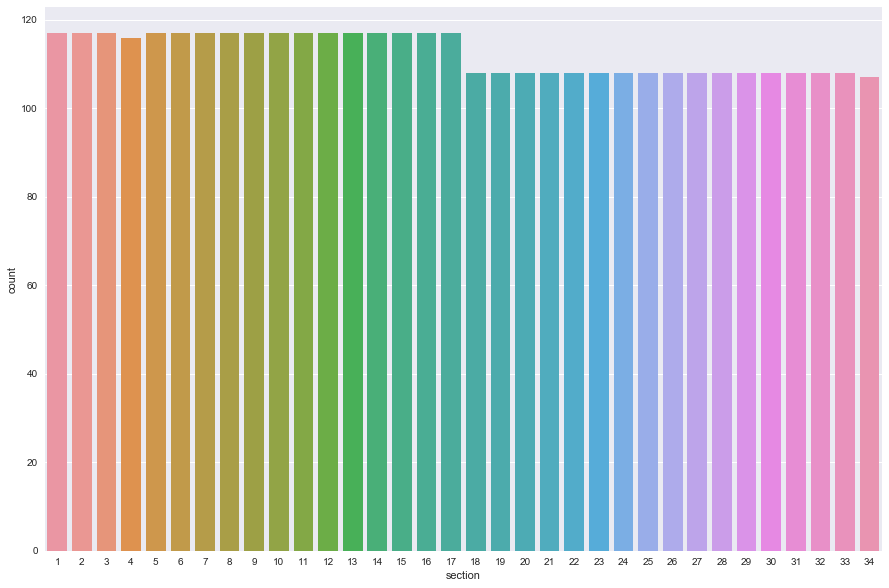

In [33]:
plt.figure(figsize=(15,10))
sns.countplot(x='section',data=total_df)

In [34]:
total_df

,attendance,away_team,broadcasters,home_team,humidity,id,kick_off_time,match_date,match_date_day,match_date_month,match_date_year,round,section,temperature,venue,weather,capacity,holiday
0,20916.0,浦和,NHK総合/J SPORTS(録),G大阪,40.0,9190,16,2006-03-04,4,3,2006,1,1,8.3,万博記念競技場,晴,21000,1
1,14277.0,清水,山梨放送/テレビ静岡(録)/J SPORTS(録),甲府,28.0,9191,13,2006-03-05,5,3,2006,2,1,12.9,山梨県小瀬スポーツ公園陸上競技場,晴,15859,1
2,22531.0,大分,BS-i/MXテレビ(録)/J SPORTS(録),FC東京,35.0,9192,13,2006-03-05,5,3,2006,2,1,12.1,味の素スタジアム,晴,48999,1
3,28564.0,福岡,J SPORTS,磐田,42.0,9193,14,2006-03-05,5,3,2006,2,1,11.6,静岡スタジアムエコパ,晴,51697,1
4,17199.0,C大阪,スカイパーフェクTV!/NHK名古屋(録)/NHK大阪(録)/J SPORTS(録),名古屋,32.0,9194,14,2006-03-05,5,3,2006,2,1,13.1,名古屋市瑞穂陸上競技場,晴,20223,1
5,13085.0,千葉,テレビ埼玉/BS(録)/J SPORTS(録),大宮,33.0,9195,15,2006-03-05,5,3,2006,2,1,12.6,埼玉スタジアム2002,晴,62010,1
6,17444.0,新潟,J SPORTS(録),川崎F,34.0,9196,15,2006-03-05,5,3,2006,2,1,13.3,等々力陸上競技場,晴,26827,1
7,17564.0,鹿島,BS/J SPORTS(録),広島,58.0,9197,15,2006-03-05,5,3,2006,2,1,12.4,広島ビッグアーチ,曇,36894,1
8,23607.0,京都,BS-i/KBS京都(録)/J SPORTS(録),横浜FM,34.0,9198,15,2006-03-05,5,3,2006,2,1,12.6,日産スタジアム,晴,72081,1
9,56512.0,磐田,TBS(単)/静岡放送/テレビ埼玉(録)/J SPORTS(録),浦和,48.0,9199,14,2006-03-11,11,3,2006,1,2,16.0,埼玉スタジアム2002,晴,62010,1


### 気温湿度

歪度： -0.4609354954071078
尖度： -0.5237434140181434
歪度： -0.23223091860191594
尖度： -0.8124182860319458


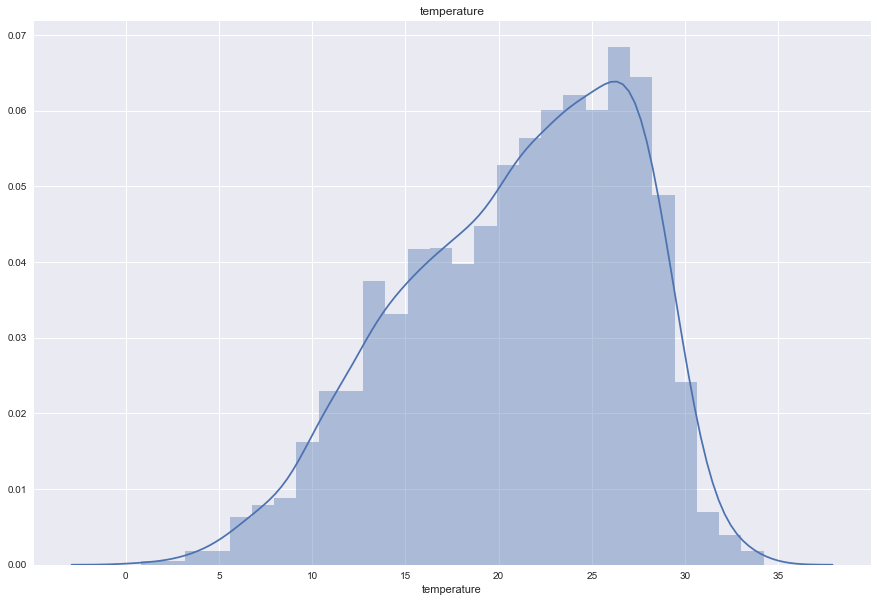

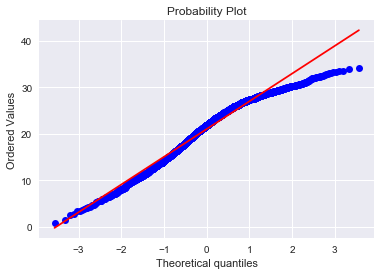

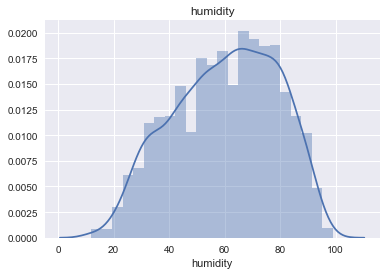

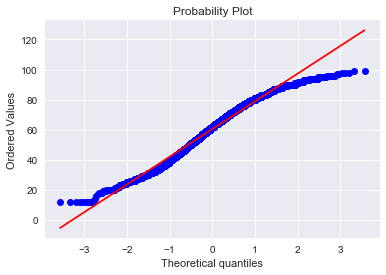

In [35]:
plt.figure(figsize=(15,10))
sns.distplot(total_df.temperature)
plt.title('temperature')

print('歪度：',stats.skew(total_df.temperature))
print('尖度：',stats.kurtosis(total_df.temperature))

fig = plt.figure()
res = stats.probplot(total_df.temperature, plot=plt)

plt.figure()
sns.distplot(total_df.humidity)
plt.title('humidity')

fig = plt.figure()
res = stats.probplot(total_df.humidity, plot=plt)

print('歪度：',stats.skew(total_df.humidity))
print('尖度：',stats.kurtosis(total_df.humidity))

##### ビン分割
気温がまあまあ歪んでいる

In [36]:
total_df.describe()

,attendance,humidity,id,kick_off_time,match_date_day,match_date_month,match_date_year,round,section,temperature,capacity,holiday
count,3364.000000,3823.000000,3823.000000,3823.000000,3823.000000,3823.000000,3823.000000,3823.000000,3823.000000,3823.000000,3823.000000,3823.000000
mean,17971.165279,60.392362,14230.161130,16.550876,16.497777,6.846717,2011.758828,1.217892,17.159037,21.025974,31780.394193,0.900602
std,9462.579483,18.631907,3255.280615,2.205071,8.824377,2.644573,3.615249,0.441649,9.802568,6.061011,16100.836699,0.299235
min,3594.000000,12.000000,9190.000000,12.000000,1.000000,2.000000,2006.000000,1.000000,1.000000,0.800000,12584.000000,0.000000
25%,11495.750000,46.000000,11653.500000,14.000000,9.000000,4.000000,2009.000000,1.000000,9.000000,16.600000,19694.000000,1.000000
50%,15327.500000,62.000000,14069.000000,16.000000,17.000000,7.000000,2012.000000,1.000000,17.000000,21.800000,26827.000000,1.000000
75%,21091.250000,76.000000,16917.500000,19.000000,24.000000,9.000000,2015.000000,1.000000,26.000000,26.000000,41255.000000,1.000000
max,62632.000000,99.000000,20897.000000,20.000000,31.000000,12.000000,2018.000000,4.000000,34.000000,34.200000,72081.000000,1.000000


In [37]:
temp = pd.cut(total_df['temperature'],[0,5,10,15,20,25,30,np.inf],labels=['5以下','10以下','15以下','20以下','25以下','夏日','真夏日'])
total_df['temp_bin']=temp

In [38]:
#humi = pd.cut(total_df['humidity'],[0,40,70,np.inf],labels=['aridity','proper','disconfort'])
#total_df['humi_bin']=humi

### 天気変換

ダミー変数で置き換える。（例：晴れのち曇り⇒晴れ：１、曇り：１、雨：０）

In [39]:
total_df["weather"].value_counts()

晴           1905
曇            992
雨            291
屋内           105
曇のち雨          89
晴のち曇          83
雨のち曇          76
曇のち晴          57
曇時々雨          44
曇時々晴          39
晴時々曇          34
曇一時雨          28
晴のち雨          10
雨時々曇           9
晴一時曇           7
晴一時雨           6
曇一時晴           6
雨一時曇           4
曇のち雨のち曇        2
雨のち曇のち晴        2
雨のち曇一時雨        2
雨一時雷雨          2
晴のち曇一時雨        2
晴一時雨のち曇        2
曇一時雨のち曇        1
曇時々雪           1
晴時々曇一時雨        1
曇のち雷雨          1
曇のち雨一時雷        1
雨一時曇のち雨        1
霧              1
雷雨のち曇          1
晴時々雪           1
曇のち霧           1
晴のち雪           1
雪              1
雨のち曇時々雨        1
曇時々晴のち屋内       1
雨時々晴           1
曇一時雷雨のち曇       1
曇一時雨のち晴        1
曇時々雨のち晴        1
曇のち雨のち屋内       1
雨のち晴           1
雨のち曇のち雨        1
曇のち雨のち晴        1
曇晴             1
曇時々晴一時雨        1
曇一時雷雨のち雨       1
曇時々雨のち曇        1
Name: weather, dtype: int64

In [40]:
weathers = ['晴','曇','雨','屋内']
#total_df.weather = total_df.weather.map(lambda x: '雨' if x in ['雪','雷','霧'] else x)
for weather in weathers:
    total_df["weather_"+weather] = (total_df["weather"].str.contains(weather) )+0

雪、雷、霧も雨として考える

In [41]:
total_df["weather_雨"] = ((total_df['weather'].str.contains('雨'))|(total_df['weather'].str.contains('雪'))|(total_df['weather'].str.contains('雷'))|(total_df['weather'].str.contains('霧')))+0

In [42]:
total_df.groupby(['weather_雨']).attendance.mean()

weather_雨
0    18147.617141
1    16999.485493
Name: attendance, dtype: float64

In [43]:
total_df.groupby(['weather_晴']).attendance.mean()

weather_晴
0    17481.043836
1    18346.993697
Name: attendance, dtype: float64

In [44]:
total_df.groupby(['weather_曇']).attendance.mean()

weather_曇
0    18174.315815
1    17659.708584
Name: attendance, dtype: float64

### その時の順位など

In [45]:
%%time
home_rank = []
away_rank = []
for i in range(len(total_df)):
    home_rank.append(rank_df[(rank_df['match_date_year']==total_df.match_date_year.iloc[i])&(rank_df['section']==total_df.section.iloc[i])&(rank_df['team']==total_df.home_team.iloc[i])]['rank'].values[0])
    away_rank.append(rank_df[(rank_df['match_date_year']==total_df.match_date_year.iloc[i])&(rank_df['section']==total_df.section.iloc[i])&(rank_df['team']==total_df.away_team.iloc[i])]['rank'].values[0])  
        
total_df['home_rank'] = home_rank
total_df['away_rank'] = away_rank

Wall time: 25.8 s


In [46]:
total_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3823 entries, 0 to 458
Data columns (total 25 columns):
attendance          3364 non-null float64
away_team           3823 non-null object
broadcasters        3823 non-null object
home_team           3823 non-null object
humidity            3823 non-null float64
id                  3823 non-null int64
kick_off_time       3823 non-null int64
match_date          3823 non-null datetime64[ns]
match_date_day      3823 non-null int64
match_date_month    3823 non-null int64
match_date_year     3823 non-null int64
round               3823 non-null int64
section             3823 non-null int64
temperature         3823 non-null float64
venue               3823 non-null object
weather             3823 non-null object
capacity            3823 non-null int64
holiday             3823 non-null int64
temp_bin            3823 non-null category
weather_晴           3823 non-null int32
weather_曇           3823 non-null int32
weather_雨           3823 non-nu

In [47]:
aaa = total_df.dropna()

Wall time: 2.55 s


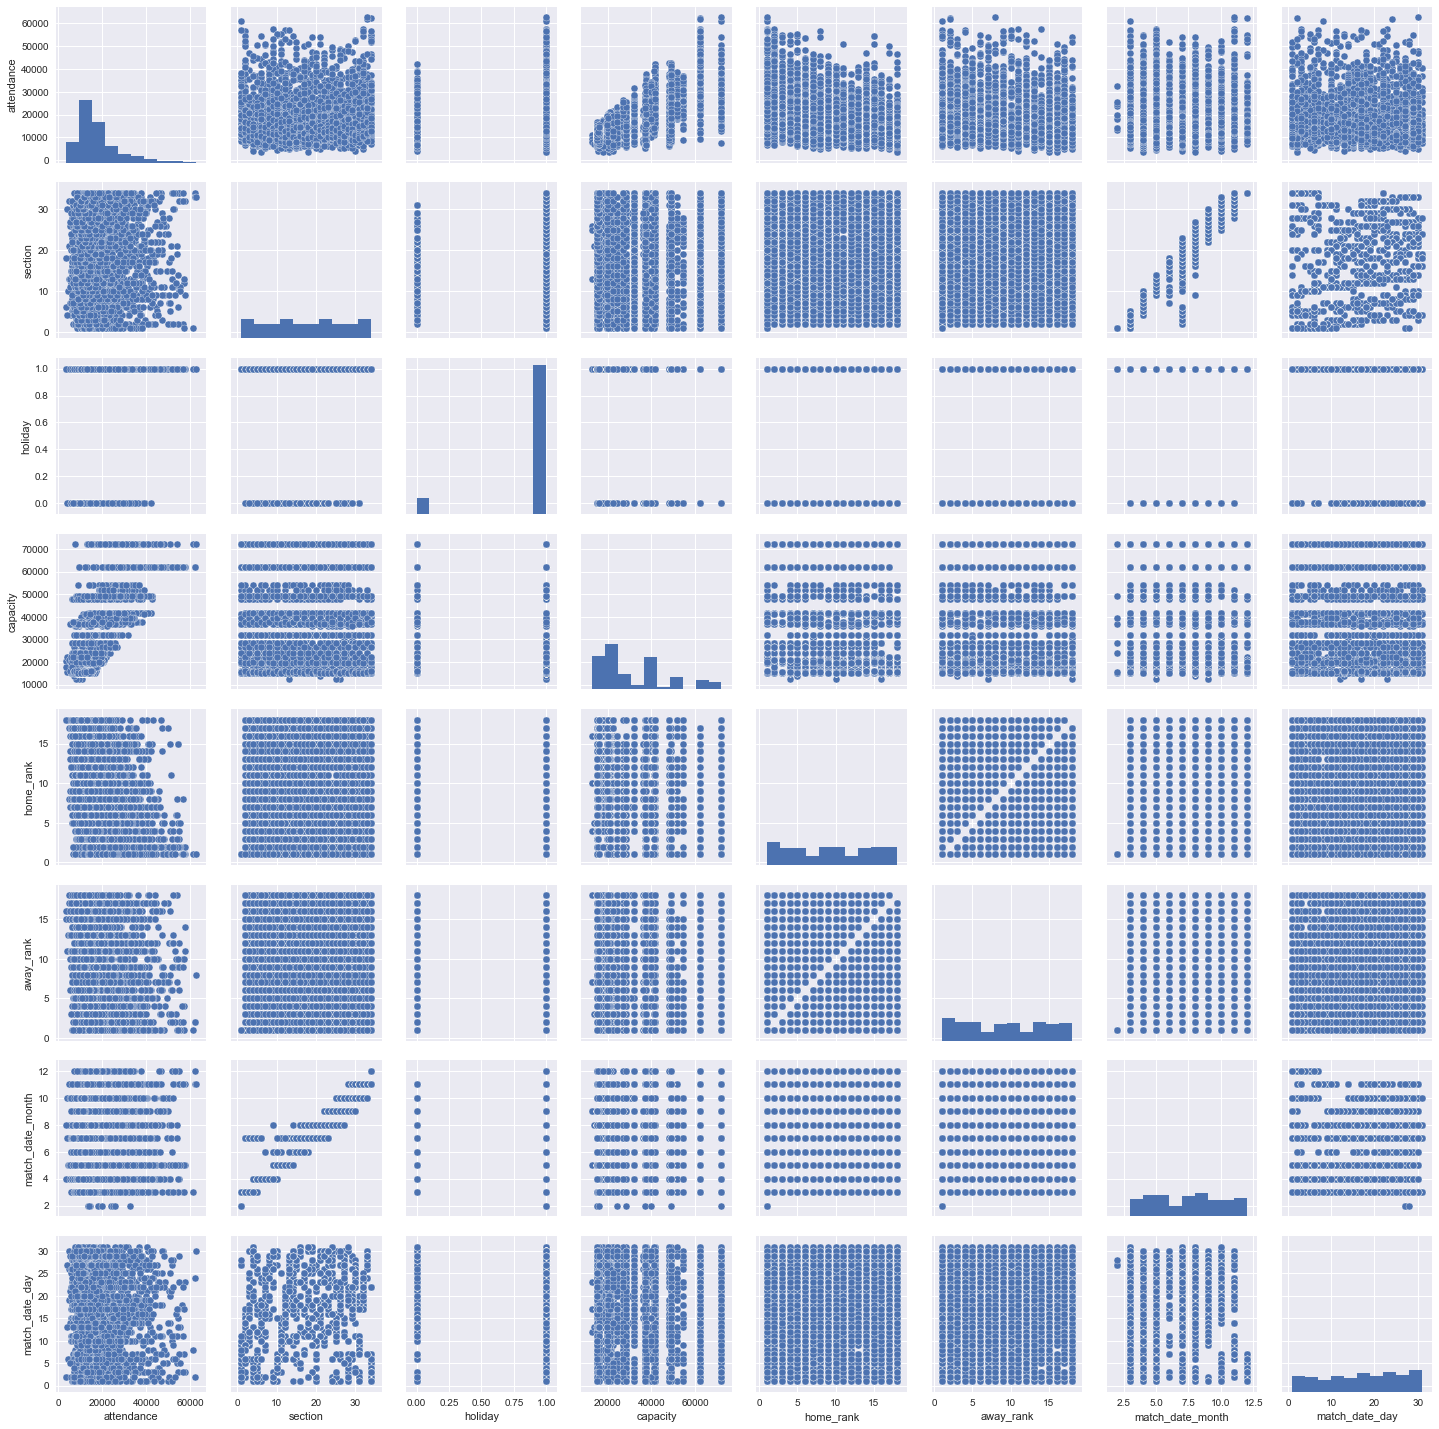

In [49]:
%%time
sns.pairplot(aaa[['attendance','section','holiday','capacity','home_rank','away_rank','match_date_month','match_date_day']])

### HAチーム名

In [47]:
teams = set(total_df["home_team"].unique().tolist() + total_df["away_team"].unique().tolist())
print(teams)

for team in teams:
    total_df["home_team_" + team] = (total_df["home_team"] == team) +0
    total_df['away_team_' + team] = (total_df["away_team"] == team) +0
    #total_df["team_" + team] = ((total_df["home_team"] == team) | (total_df["away_team"] == team))+0

{'甲府', '神戸', '山形', '東京V', '大分', '新潟', '柏', '名古屋', '仙台', 'C大阪', 'G大阪', '川崎F', '京都', '磐田', '長崎', '浦和', '札幌', '清水', '徳島', '松本', '広島', '千葉', '横浜FC', '湘南', '横浜FM', '鳥栖', '鹿島', '大宮', 'FC東京', '福岡'}


### broadcasters

In [48]:
total_df['broadcasters'].value_counts()

スカパー!/スカパー!プレミアムサービス                             805
DAZN                                             260
スカパー/e2/スカパー光                                    220
スカパー(スカチャンHD、スカチャン)/e2スカチャンHD                    179
スカパー!/スカパー!プレミアムサービス/NHK BS1                     129
スカパー(スカチャンHD、スカチャン)/e2スカチャン                      111
スカパー!(パーフェクト チョイス)/e2(スカチャン!)                    110
スカパー!(パーフェクト チョイス)/e2(スカチャン!HV)                   74
DAZN/NHK BS1                                      52
BS/J SPORTS(録)                                    50
スカパー・e2(J sports Plus)                            45
J SPORTS(録)                                       44
スカパー・e2(TBSチャンネル)/BS-TBS                          42
スカパー(スカチャンHD、スカチャン)/e2スカチャン/BS                    40
スカパー!・e2(J sports Plus)                           34
BS-i/J SPORTS(録)                                  31
スカパー/e2/スカパー光/ひかりTV                               31
スカパー!・e2(TBSチャンネル)/BS-i                           30
スカパー!/スカパー!プレミアムサービス/テレ玉                      

In [49]:
dirty_casters = set()
for casters in total_df["broadcasters"].str.split("/"):
    dirty_casters.update(casters)

In [50]:
# ※以降はチャンネルと関係ない
# スカパー!関連が!がなかったりSportsのスペルや大文字小文字がぐちゃぐちゃになっていて酷い
dirty_casters

{'BS',
 'BS(録)',
 'BS-TBS',
 'BS-TBS(録)',
 'BS-i',
 'BS-i(録)',
 'BS※',
 'BSーTBS',
 'BSーTBS(録)',
 'BSーi',
 'DAZN',
 'DAZN ※AFCチャンピオンズリーグ2017の影響により、G大阪vs鹿島は7月5日(水)に開催',
 'DAZN ※AFCチャンピオンズリーグ2017の影響により、川崎Fvs浦和は7月5日(水)に開催',
 'J SPORTS',
 'J SPORTS ESPN',
 'J SPORTS(録)',
 'J SPORTS2',
 'KBS京都',
 'KBS京都(録)',
 'MXテレビ',
 'MXテレビ(録)',
 'MXテレビ*',
 'NHK BS1',
 'NHK BS1 ※4 AFCチャンピオンズリーグ2016の影響により、浦和vsFC東京は6月22日(水)に開催',
 'NHK BS1 ※6 浦和がスルガ銀行チャンピオンシップ2017SAITAMAに出場のため、7月22日(土)に開催',
 'NHK BS1 ※AFCチャンピオンズリーグ2018の影響により、C大阪vs鹿島は7月25日(水)に開催',
 'NHK BS1(101ch)',
 'NHK BS1(102ch)',
 'NHK BS1(録)',
 'NHK-BSハイビジョン',
 'NHK京都',
 'NHK仙台',
 'NHK仙台 ※ AFCチャンピオンズリーグ2015準決勝の影響により、10月25日(日)に開催。',
 'NHK仙台(東北ブロック)',
 'NHK佐賀',
 'NHK名古屋',
 'NHK名古屋(録)',
 'NHK大分',
 'NHK大阪',
 'NHK大阪(近畿ブロック)',
 'NHK大阪(録)',
 'NHK山形',
 'NHK岐阜',
 'NHK岩手',
 'NHK広島',
 'NHK徳島',
 'NHK新潟',
 'NHK新潟*',
 'NHK札幌',
 'NHK水戸',
 'NHK水戸*',
 'NHK津',
 'NHK甲府',
 'NHK神戸',
 'NHK神戸(近畿ブロック)',
 'NHK神戸(録)',
 'NHK福岡',
 'NHK福島',
 'NHK秋田',
 'NHK総合',
 'NHK総合(録)',
 'NHK長崎',

In [51]:
clean_casters = set()

# ()と※より後ろを消す
# 小文字を大文字に統一
# ーを-に変換する
# スカパー派生は全てスカパーに統一

def cleanify(caster):
    caster = caster.upper()
    caster = re.sub("\(.+\)|\*", "", caster)
    caster = caster.split("※")[0]\
               .rstrip(" ")\
               .replace("ー", "-")\
               .replace(" ", "_")
    if caster[:4] == "スカパ-":
        caster = "スカパー"
    return caster

for caster in dirty_casters:
    clean_casters.add(cleanify(caster))

In [52]:
tmp = total_df["broadcasters"].str.split("/")\
                              .apply(lambda casters: [cleanify(caster) for caster in casters])
total_df["broadcasters"] = tmp

for caster in clean_casters:
    total_df["broadcasters_{}".format(caster)] = total_df["broadcasters"].apply(lambda casters: caster in casters)

# データの準備

In [53]:
total_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3823 entries, 0 to 458
Columns: 179 entries, attendance to broadcasters_NHK山形
dtypes: bool(94), category(1), datetime64[ns](1), float64(3), int32(64), int64(11), object(5)
memory usage: 2.0+ MB


In [54]:
total = total_df
total = total.drop(['match_date','weather','venue','temperature','humidity','home_team','away_team','broadcasters',],axis=1)

In [55]:
# 全体の1%に満たないbool値は消す
threshold = 0.01
bool_df = total.select_dtypes("bool")
del_col = (bool_df.sum(axis=0)[bool_df.sum(axis=0) <= train_df.shape[0] * threshold]).index.tolist()
total.drop(del_col, axis=1, inplace=True)

In [56]:
total = pd.get_dummies(total)

In [57]:
train_df = total.query("id < 19075")
test_df = total.query("id >= 19075")

In [58]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3364 entries, 0 to 3365
Columns: 105 entries, attendance to temp_bin_真夏日
dtypes: bool(22), float64(1), int32(64), int64(11), uint8(7)
memory usage: 1.2 MB


## hold-out検証

In [59]:
# 今回は時系列データなので、ある期間との前後でデータを分ける
# 2015年までのデータを訓練データ
# 2016年のデータを検証用データにする
# 評価関数はRMSLEなので、あらかじめ目的変数のlogをとっておく

all_train_X = train_df.query("match_date_year <= 2016").drop(["id", "attendance"], axis=1)
all_train_y = np.log1p(train_df.query("match_date_year <= 2016")["attendance"])

train_X = train_df.query("match_date_year <= 2015").drop(["id", "attendance"], axis=1)
train_y = np.log1p(train_df.query("match_date_year <= 2015")["attendance"])

val_X = train_df.query("match_date_year == 2016").drop(["id", "attendance"], axis=1)
val_y = np.log1p(train_df.query("match_date_year == 2016")["attendance"])

test_X = test_df.drop(["id",'attendance'], axis=1)

# モデリング

### XGB

train_score: 0.055616
val_score: 0.2123
Wall time: 14.2 s


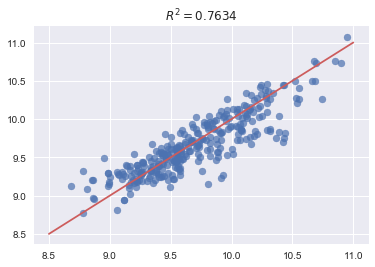

In [60]:
%%time
import xgboost as xgb
from sklearn import model_selection

Xgb = xgb.XGBRegressor(max_depth=6,n_estimators=400)

Xgb.fit(train_X, train_y)
train_pred_xgb = Xgb.predict(train_X)
val_pred_xgb = Xgb.predict(val_X)

print("train_score: {:<.5}".format(np.sqrt(mean_squared_error(train_y, train_pred_xgb))))
print("val_score: {:<.5}".format(np.sqrt(mean_squared_error(val_y, val_pred_xgb))))

#validationのずれを確認する
from sklearn.metrics import r2_score
plt.figure()
plt.scatter(val_y, val_pred_xgb, alpha=0.7)
plt.title("$R^2 = {:<.5}$".format(r2_score(val_y, val_pred_xgb)))
x = np.linspace(8.5, 11, 100)
plt.plot(x, x, c="indianred")

### 提出

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed: 14.9min finished


{'max_depth': 6, 'n_estimators': 400} 0.7497247808684386
train_score: 0.055616
val_score: 0.2123


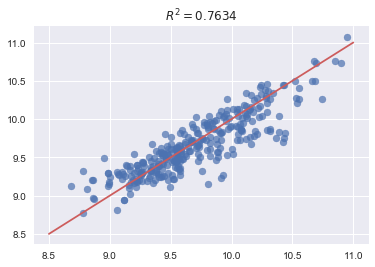

In [67]:
import xgboost as xgb
from sklearn import model_selection
clf = xgb.XGBRegressor()

xgb_cv = model_selection.GridSearchCV(clf, {'max_depth': [2,3,4,5,6], 'n_estimators': [200,300,400,500]}, verbose=1)

xgb_cv.fit(train_X, train_y)

print(xgb_cv.best_params_, xgb_cv.best_score_)

# 改めて最適パラメータで学習
Xgb = xgb.XGBRegressor(**xgb_cv.best_params_)
Xgb.fit(train_X, train_y)

train_pred = Xgb.predict(train_X)
val_pred = Xgb.predict(val_X)

print("train_score: {:<.5}".format(np.sqrt(mean_squared_error(train_y, train_pred))))
print("val_score: {:<.5}".format(np.sqrt(mean_squared_error(val_y, val_pred))))


#validationのずれを確認する
from sklearn.metrics import r2_score
plt.figure()
plt.scatter(val_y, val_pred_xgb, alpha=0.7)
plt.title("$R^2 = {:<.5}$".format(r2_score(val_y, val_pred_xgb)))
x = np.linspace(8.5, 11, 100)
plt.plot(x, x, c="indianred")


<BarContainer object of 103 artists>

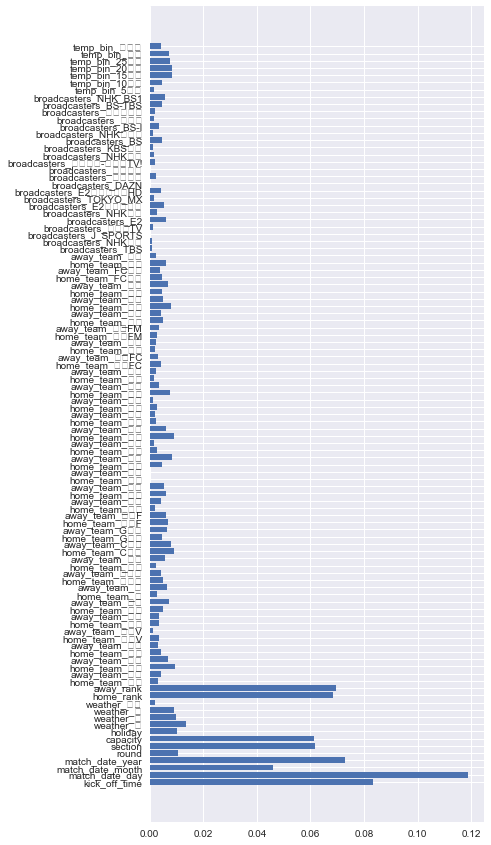

In [66]:
# どの特徴量が有効だったか確認
# capacityが特徴量として一番効いている
plt.figure(figsize=(6, 15))
plt.barh(train_X.columns, Xgb.feature_importances_)

In [64]:
Xgb = xgb.XGBRegressor(max_depth=6,n_estimators=400)
Xgb.fit(all_train_X, all_train_y)
test_pred = Xgb.predict(test_X)
smpsb_df.iloc[:len(test_X), 1] = np.expm1(Xgb.predict(test_X)) 
# コードの提出
smpsb_df.to_csv("./output/result24.csv", index=None, header=None)